# Numerical simulation of the wave equation in 1D using Finite Difference

## Import libraries

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython.display import HTML
import sys

----

## Create domain model properties (i.e. speed of waves), and discretisation grid

In [13]:
length = 10.0  # assign a length to the model, and we're working in metres

nx = 201  # 201 sample-points along the x-axis

# start with homogeneous model - same wave-speed everywhere.
c = np.full(nx,10.0)  # 10m/s

In [14]:
# There are 200 gaps *between* the 201 sample-points, so sample spacing is the length divided by nx-1

dx = length/(nx-1)  # calculate the spacing between sample-points

print('Domain is %.1fm, with %d sample-points' % (length,nx))
print('Sample-point spacing (dx) is %.5fm' % (dx))

Domain is 10.0m, with 201 sample-points
Sample-point spacing (dx) is 0.05000m


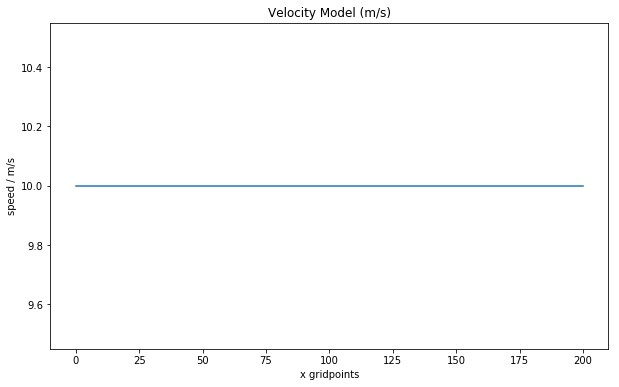

In [15]:
plt.figure(figsize=(10,6))
plt.plot(c) # plotting the velocity model
plt.xlabel('x gridpoints')
plt.ylabel('speed / m/s')
plt.title('Velocity Model (m/s)')
plt.show()

----
## Time-stepping grid...


In [16]:
# let's start with time-step of 0.004s
dt = 0.004  # will see later that we can't generally pick just anything - try doubling this, for example...
nt = 500    # 500 time-steps, at 0.004s each, gives...
time = nt*dt  # ...total time of 2s
print('Time-step = %.5fs  Number of steps = %d  (Total time being modelled: %.5fs)' % (dt,nt,time))

Time-step = 0.00400s  Number of steps = 500  (Total time being modelled: 2.00000s)


----
# Time-stepping

We know we want to simulate solutions to the 1d wave equation:

$$\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}$$

And we've worked out how we can discretise it using a simple 2nd-order (in both space & time) Finite Difference method:

$$\quad u_\xi^{\tau+1}\ \approx \ \delta t^2c^2_\xi\left(\frac{u_{\xi+1}^\tau-2u_\xi^\tau+u_{\xi-1}^\tau}{\delta x^2}\right) + 2u_\xi^\tau - u_\xi^{\tau-1}$$

From above we can see that the wavefield at time point $\tau$+1 can be worked out from wavefields at $\tau$ and $\tau$-1.

In other words, to find the next wavefield we need the previous two wavefields...

So let's create three arrays to store these three 'time-levels':

In [17]:
# Create three arrays for wavefields:
u = np.zeros(nx)     # current wavefield during step at time t
u_prv = np.zeros(nx) # previous wavefield, at time t-dt
u_nxt = np.zeros(nx) # next wavefield, at time t+dt

## Initial condition for normal modes

The equation for the $N^{\text{th}}$ normal mode, with zero boundary conditions at the two ends of the domain, $x$=0 and $x$=$L$, and with wave speed $c$, and starting from a sine wave at maximum amplitude when $t$=0, is:

$$u(x,t)\ =\ \sin(N\pi\frac{x}{L})\ \cos(N\pi\frac{ct}{L})$$

>**Task 1:**
>
>**Use the above equation to create code below to initialise the arrays `u` and `u_prv` for numerical simulation of normal modes.**
>
>**The variable `mode` in the code cell below corresponds to $N$ in the equation above, and $L$ is the `length` of the domain.**
>
>**The simulation should work for integer values of `mode` from one to at least ten.**


In [18]:
# the mode should change the number of peaks+troughs across the domain
# (also changes oscillation frequency)

def init_normal_mode(mode):

    # FILL IN CODE HERE for task 1...

    for ix in range(nx):
        u_prv[ix] = np.sin(mode*np.pi*ix/(nx-1))

    u[:] = u_prv[:]*np.cos(mode*np.pi*c[:]*dt/length)


In [19]:
# define a function to plot initial wavefields
# (in practice, we may not see u_prv if u is so close that it's basically on top of u_prv)
def plot_initial():
    fig = plt.figure(figsize=[15,5])
    plt.plot(np.array(range(nx))*dx,u_prv)  # plot u_prv (first curve gets plotted in blue)
    plt.plot(np.array(range(nx))*dx,u)      # and plot u on same figure (second curve in red)
    plt.title('Initial wavefields')
    plt.xlabel('x-position / m')
    plt.ylabel('amplitude')
    plt.show()

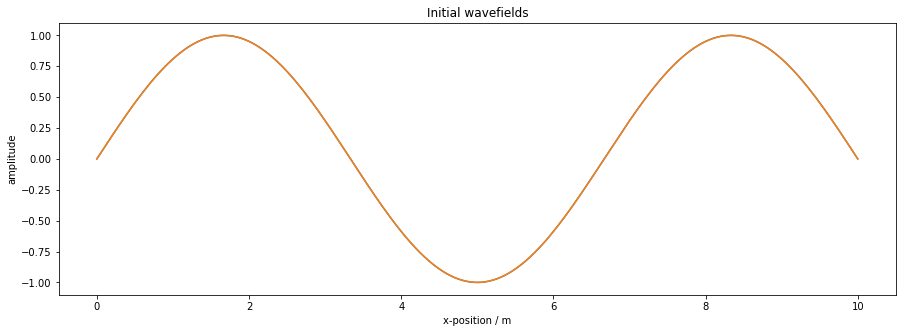

In [20]:
# We can now call above function to initialise wavefields, and check they look ok
init_normal_mode(3)  # try for different mode integers -should work up to at least 10
plot_initial()

In [21]:
# prepare an array to store wavefield snapshots for plotting/animating later

snapshot_gap = 5  # set sampling rate used to store wavefield (every 5 timesteps)
wavefield = np.zeros((int(nt/snapshot_gap), nx))  # array to store wavefields every 5 timesteps
print('Storing %d wavefields (every %dth out of %d)' % (wavefield.shape[0],snapshot_gap,nt))

Storing 100 wavefields (every 5th out of 500)



## Discretisation and propagation
The simple second-order discretisation approximation we worked out for the 1d wave equation is:

$$\quad u_\xi^{\tau+1}\ \approx \ \frac{\delta t^2c^2_\xi}{\delta x^2}\left(u_{\xi+1}^\tau-2u_\xi^\tau+u_{\xi-1}^\tau\right) + 2u_\xi^\tau - u_\xi^{\tau-1}$$

>**Task 2:**
>
>**From the above discretisation equation, fill in code below (where indicated within the time loop) to step forwards in time.**  
>
>**– Use the 3 arrays, `u_prv`, `u` & `u_nxt`, that were created above, for the 3 time positions, $\tau\text{-1}$, $\tau$ and $\tau\text{+1}$.**    
>$\quad$(Remember that you will need to 'cycle' the wavefields at the end of a time-step, ready to start the next one...)

In [22]:
# define a time-stepping wavefield propagation function...

def propagate():

    for i in range(nt):

        if i%20==0:  # show progress every 20 steps
            sys.stdout.write('Doing %d of %d\r' % (i+1,nt))



        # FILL IN CODE HERE TO PERFORM A SINGLE TIME STEP (task 2)...

        for ix in range(1,nx-1):
            u_nxt[ix] = ((dt*c[ix]/dx)**2) * (u[ix+1]-u[ix]*2+u[ix-1]) + u[ix]*2 - u_prv[ix]

        # cycle the wavefields, ready for the next step...
        u_prv[:] = u[:]
        u[:] = u_nxt[:]
    
    
        # store the current wavefield u on every 5th step, so we can plot space-time pic below
        if (i+1)%snapshot_gap == 0:
            wavefield[int((i+1)/snapshot_gap-1),:] = u[:]

    print('Finished all %d steps' % (nt))

In [23]:
# now let's do the propagation...
propagate()

Finished all 500 steps


----
## Plot wavefield at different times

In [24]:
# define a function we can use to plot wavefield snapshots in (approx) time
def plot_snapshot(plot_time):
    plt.figure(figsize=(15,5))
    plt.plot(np.array(range(nx))*dx,wavefield[int(plot_time/(dt*snapshot_gap)),:])
    plt.title('Wavefield at %.3fs' % (plot_time))
    plt.xlabel('x-position / m')
    plt.ylabel('amplitude')
    plt.show()

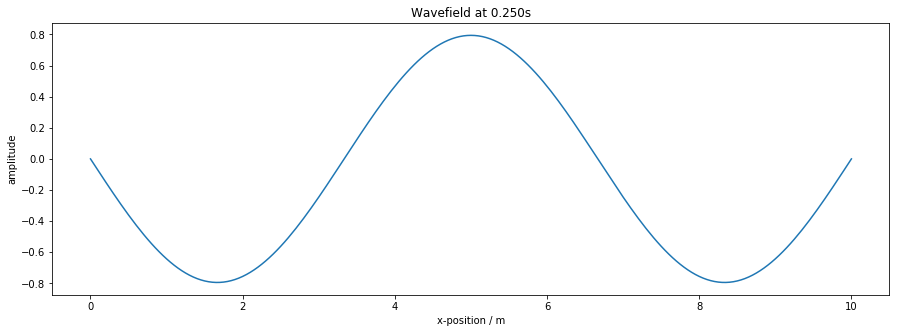

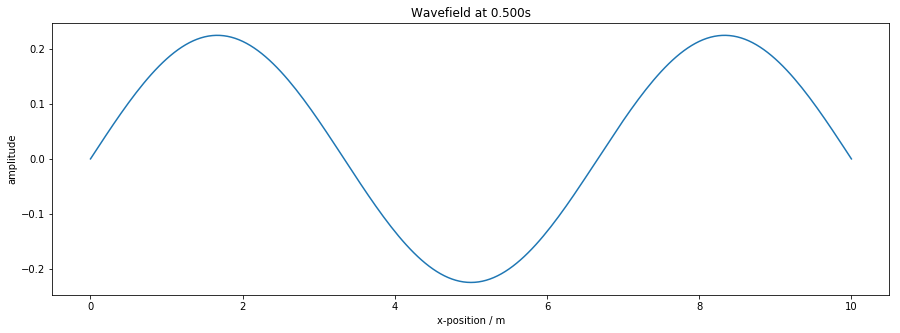

In [25]:
# Plot at (approx) 0.25s and 0.5s
plot_snapshot(0.25)
plot_snapshot(0.5)

## Show space-time plot for whole wavefield

In [26]:
# define a function we can use again later changing to different initial conditions...
def plot_spacetime():
    fig = plt.figure(figsize=(10,8))
    plt.imshow(wavefield, cmap='RdBu', interpolation='bilinear', aspect='auto',
               vmin=-1, vmax=1,       # set the bounds for the colour data
               extent=(0,length,time,0))  # set the bounds for the axes
    plt.title('Wavefield propagation with time')
    plt.xlabel('x-position / m')
    plt.ylabel('Time / s')
    plt.show()

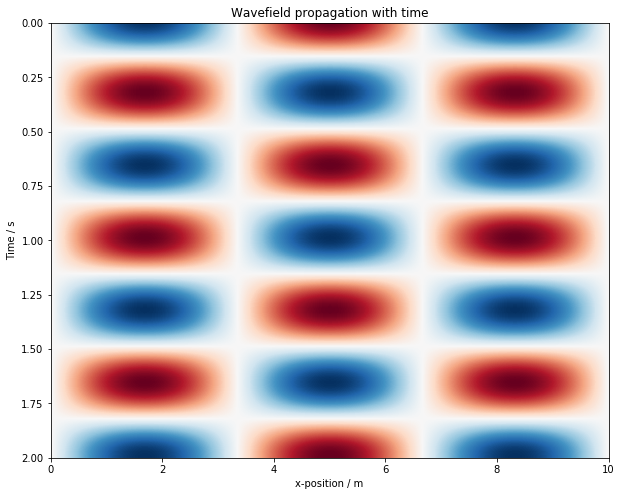

In [27]:
# Plot what we have so far...
plot_spacetime()

## Make a movie! 

In [28]:
# define a function we can use later, etc...

def create_animation():
    fig, ax = plt.subplots(figsize=(15,6))

    x = np.arange(0, nx*dx, dx)
    line, = ax.plot(x,wavefield[0])

    plt.title('Wavefield')
    plt.xlabel('x-position / m')
    plt.ylabel('amplitude')
    plt.ylim(-1.3,1.3)

    def frame(i):
        line.set_ydata(wavefield[i])
        return line,

    print('Finished plots for frames, building animation...')

    ani = anim.FuncAnimation(fig, frame, interval=50, save_count=wavefield.shape[0])

    plt.close(fig)  # prevent final image from showing up inline when calling this function
    return ani


In [29]:
# show the animation for whatever we have so far...
ani = create_animation()
print('Preparing HTML for animation (takes a little while...)')
HTML(ani.to_jshtml())

Finished plots for frames, building animation...
Preparing HTML for animation (takes a little while...)


----
## Initial condition for travelling wave ('cosine bump')

This cosine-squared equation gives a 'bump' that is symmetric about $x$=0:

$$c(x) = \cos^2\left(\frac{\pi x}{2h}\right)\quad\text{defined for $x$=$-h$ to $h$, where $h$ is the half-width}$$

>**Task 3:**
>
>**We would like to see waves actually propagating across the domain.** (I mean, that's what we expect waves to do, right...?)
>
>**So, rather than initialising the first two wavefields with sine waves that span the whole domain, instead start them off zero everywhere except for a propagating 'bump', defined by the cosine-squared equation above.**
>
>**The 'bump' should start at time** $t$=0 **(i.e. initialising `u_prv`) so that it is centred at position `bump_mid` (in metres) of the domain, and have total non-zero width of `bump_width` (in metres).**
>
>**We want it to be travelling to the right at the appropriate speed in the model, i.e. using value for $c$ where it is located (so it travels distance $c\delta t$ in one step) – so use that information to initialise array `u`.**

In [ ]:
def init_cosine_bump(bump_mid, bump_width):

    # FILL IN CODE BELOW TO INITIALISE ARRAYS u & u_prv WITH A TRAVELLING COSINE BUMP (task 3)...
    # (remember that bump_mid & bump_width are in metres, not sample-point positions!)

    sm = bump_mid/dx
    sw = bump_width/dx

    for ix in range(nx):
        if abs(sm-ix)<sw/2:  # within the range of the bump
            u_prv[ix] = np.cos(np.pi*(sm-ix)/sw)**2
        else:
            u_prv[ix] = 0.0  # make sure the rest are correctly zeroed


    dist = c[int(sm)]*dt/dx  # distance it moves in one time-step -measured in sample-points!

    for ix in range(nx):
        if abs(sm+dist-ix)<sw/2:  # within the range of the slightly moved bump
            u[ix] = np.cos(np.pi*(sm+dist-ix)/sw)**2
        else:
            u[ix] = 0.0  # make sure the rest are correctly zeroed


In [ ]:
# Call above to initialise bump with width 1m and peak located 2m along domain, moving to the right
init_cosine_bump(2.0,1.0)

# plot initial wavefields
plot_initial()

In [ ]:
# propagate, and plot at time 0.25s and 0.5s
propagate()
plot_snapshot(0.25)
plot_snapshot(0.5)

In [ ]:
plot_spacetime()

In [ ]:
# show the animation for travelling cosine bump
ani = create_animation()
print('Preparing HTML for animation (takes a little while...)')
HTML(ani.to_jshtml())